# Multi-dimensional convolution timing benchmarks - single virtual source

### Author: M.Ravasi

This notebook perfoms multi-dimensional convolution with the same reflection response(s) used in the Marchenko redatuming examples with the aim of comparing the performance of the core operation with respect to *data size* and *number of compute resources*. 

Here, we consider the case with a single virtual source. The notebook **MDCmulti_timing** is used to perform the same with multiple virtual sources

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import psutil
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import dask.array as da
import zarr
import pylops
import pylops_distributed

from datetime import date
from timeit import repeat
from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import cg, lsqr
from scipy.signal import convolve, filtfilt
from dask_jobqueue import PBSCluster
from dask.distributed import Client

from pylops.basicoperators import *
from pylops.waveeqprocessing.mdd       import MDC
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.waveeqprocessing.marchenko import directwave
from pylops.utils import dottest

from pylops_distributed.utils import dottest as ddottest
from pylops_distributed.basicoperators import Diagonal as dDiagonal
from pylops_distributed.basicoperators import Identity as dIdentity
from pylops_distributed.basicoperators import Roll as dRoll
from pylops_distributed.waveeqprocessing.mdd import MDC as dMDC
from pylops_distributed.waveeqprocessing.marchenko import Marchenko as dMarchenko
from pylops_distributed.optimization.cg import cg as dcg

In [2]:
os.environ["STORE_PATH"] = "/work51/mrava/MADA/book/edi/Marchenko/Synclinal_flatwavelet_3D/Data/"

Establish connection with Dask cluster

In [3]:
def total_ram():
    tmem = psutil.virtual_memory().total
    return '{:.1f} GB'.format(tmem / (1024.0 ** 3))

In [4]:
cluster = PBSCluster(cores=12, #16,
                     memory='128GB',
                     shebang='#!/bin/bash',
                     resource_spec='nodes=1:baloo',
                     queue='normal',
                     walltime='00:20:00',
                     project='account')

In [5]:
cluster.scale(jobs=4)

In [6]:
client = Client(cluster)

In [15]:
client.restart()
client

Client Scheduler: tcp://10.14.75.112:33747 Dashboard: http://10.14.75.112:8787/status,Cluster Workers: 4 Cores: 48 Memory: 512.00 GB


In [16]:
nworkers = len(np.array(list(client.ncores().values())))
ncores = np.sum(np.array(list(client.ncores().values())))
print('Nworkers', nworkers)
print('Ncores', ncores)

Nworkers 4
Ncores 48


## Inputs

Input parameters 

In [17]:
# MDC parameters
nfmax = 300         # max frequency for MDC (#samples)
darea = 1           # areal extent for spatial integration (not needed here...)
subsampling = 4     # subsampling of src-recs compared to original data
rechunk = True      # rechunk R
rebalance = True    # rebalance R across nodes

# Timing parameters
nrepeat = min(2, subsampling+1)
ntime = min(5, subsampling+1)

# Input file names
inputfile_aux = os.environ["STORE_PATH"]+'3DMarchenko_auxiliary_2.npz' 
zarrfile = os.environ["STORE_PATH"]+'input3D_sub%d_ffirst.zarr' % subsampling

Load auxiliary input (contains sources, recs, virtual source etc.)

In [18]:
inputdata_aux = np.load(inputfile_aux)

Read and visualize geometry

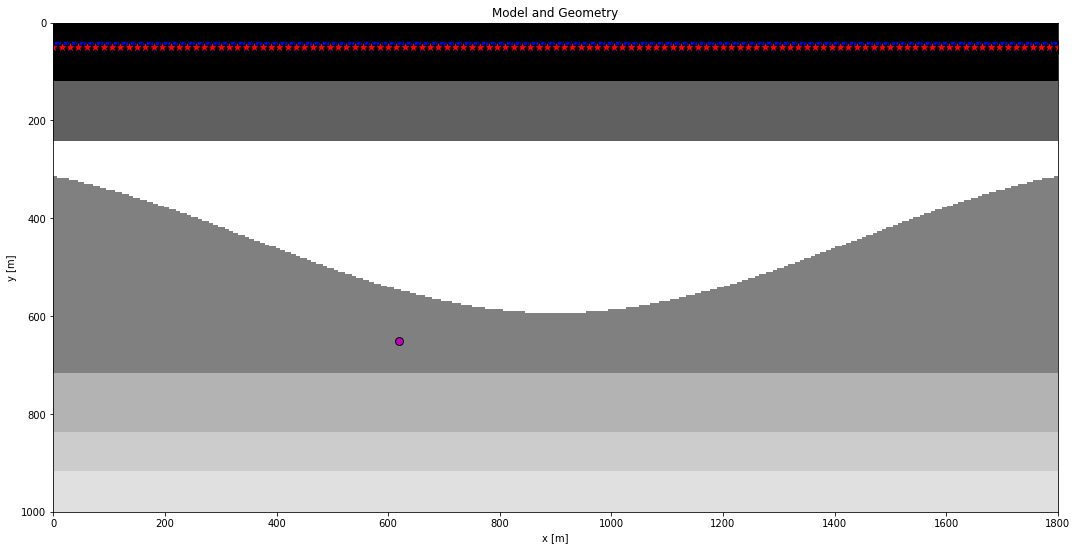

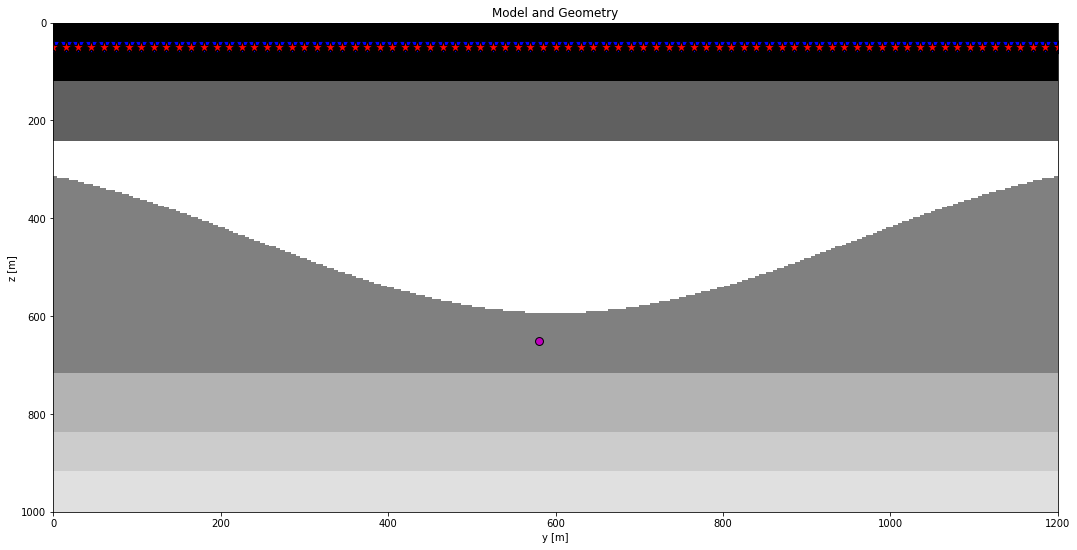

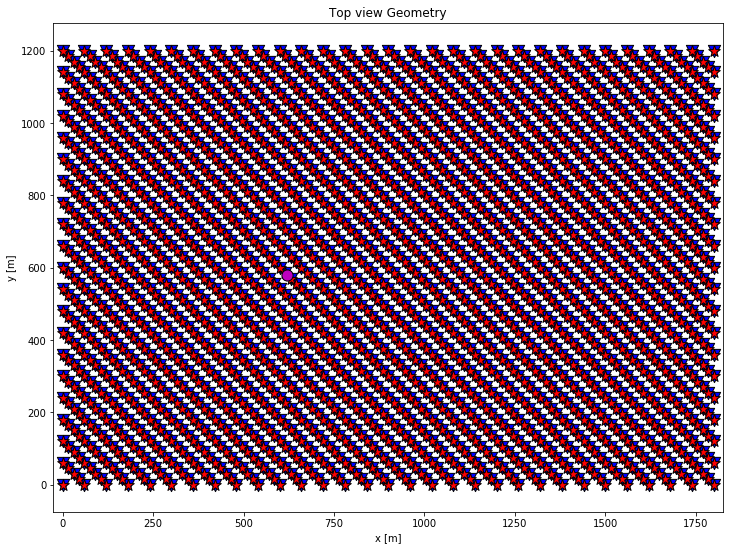

In [19]:
# Receivers
r = inputdata_aux['recs'][::subsampling].T
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = inputdata_aux['srcs'][::subsampling].T
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# Virtual points
vs = inputdata_aux['vs']

# Time axis
ot, dt, nt = 0, 2.5e-3, 601
t = np.arange(nt)*dt

# Density model
rho = inputdata_aux['rho']
z, x, y = inputdata_aux['z'], inputdata_aux['x'], inputdata_aux['y']

plt.figure(figsize=(18,9))
plt.imshow(rho[np.argmin(np.abs(x-vs[1]))].T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::10],  r[2, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[0, 5::10], s[2, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(vs[0], vs[2], marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1]);

plt.figure(figsize=(18,9))
plt.imshow(rho[np.argmin(np.abs(y-vs[0]))].T, cmap='gray', extent = (y[0], y[-1], z[-1], z[0]))
plt.scatter(r[1, ::10],  r[2, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[1, 5::10], s[2, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(vs[1], vs[2], marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('y [m]'),plt.ylabel('z [m]'),plt.title('Model and Geometry')
plt.xlim(y[0], y[-1]);

plt.figure(figsize=(12,9))
plt.scatter(r[0],  r[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[0], s[1], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(vs[0], vs[1], marker='.', s=500, c='m', edgecolors='k')
plt.axis('equal')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Top view Geometry')
plt.xlim(x[0], x[-1]);

Read subsurface fields and wavelet to apply to subsurface fields

In [20]:
G0sub = inputdata_aux['G0'][:, ::subsampling]
wav = ricker(t[:51], 20)[0]
wav_c = np.argmax(wav)

# Convolve with wavelet
G0sub = np.apply_along_axis(convolve, 0, G0sub, wav, mode='full') 
G0sub = G0sub[wav_c:][:nt]

Read Reflection response from Zarr file

In [21]:
dRtwosided_fft = 2 * da.from_zarr(zarrfile)  # 2 * as per theory you need 2*R

In [22]:
nchunks = [max(nfmax // ncores, 1), ns, nr]
if rechunk:
    dRtwosided_fft = dRtwosided_fft.rechunk(nchunks)
else:
    nchunks = dRtwosided_fft.chunksize
dRtwosided_fft = client.persist(dRtwosided_fft)
client.rebalance(dRtwosided_fft)

dRtwosided_fft

,Array,Chunk
Bytes,14.42 GB,288.36 MB
Shape,"(300, 2451, 2451)","(6, 2451, 2451)"
Count,50 Tasks,50 Chunks
Type,complex64,numpy.ndarray


Create distributed MDC operator

In [23]:
# Operator
dRop = dMDC(dRtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=darea, 
            twosided=True, saveGt=False)

# Input focusing function
dfd_plus = np.concatenate((np.fliplr(G0sub.T).T, np.zeros((nt-1, nr)))).astype(np.float32)
dfd_plus = da.from_array(dfd_plus)

Run standard redatuming as benchmark

In [24]:
dp0_minus = dRop.matvec(dfd_plus.flatten())

In [25]:
p0_minus = dp0_minus.compute()
p0_minus = p0_minus.reshape((2*nt-1), nr)

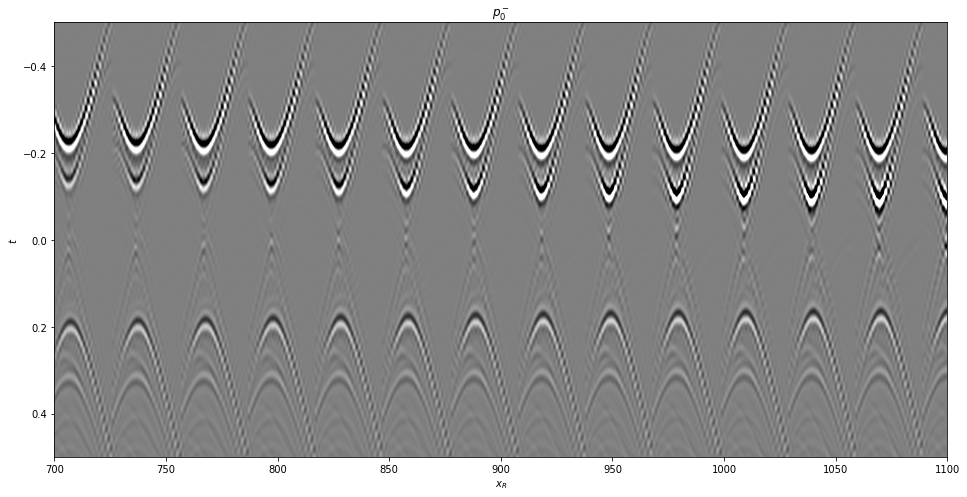

In [26]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(16, 8))
ax.imshow(p0_minus, cmap='gray', vmin=-5e0, vmax=5e0, 
          interpolation='sinc', extent=(0, nr, t[-1], -t[-1]))
ax.set_title(r'$p_0^-$')
ax.set_xlabel(r'$x_R$')
ax.set_ylabel(r'$t$')
ax.axis('tight')
ax.set_ylim(0.5, -0.5)
ax.set_xlim(700, 1100);

Time forward

In [27]:
dp0_forw = dRop.matvec(dfd_plus.flatten())

t0 = time.time()
exctime = np.array(repeat(lambda: dp0_forw.compute(), number=ntime, repeat=nrepeat))
meantime, stdtime = np.mean(exctime/ntime), np.std(exctime/ntime)
print( time.time() - t0, meantime*ntime*nrepeat)
print('Forward:', meantime, stdtime)

18.590716123580933 18.57326900959015
Forward: 1.857326900959015 0.00514632165431983


In [28]:
df = pd.DataFrame(dict(nworkers=nworkers, ncores=ncores, ram=total_ram(), 
                       subsampling=subsampling, ffirst=True,
                       meantime=meantime, stdtime=stdtime, 
                       nchunks=str(nchunks), rebalance=rebalance,
                       nrepeat=nrepeat, ntime=ntime,
                       time=date.today()), index=[0])

# add to csv file
#header=True
#if os.path.isfile('Benchmarks/benchmark_forw.csv'):
#    df_other = pd.read_csv('Benchmarks/benchmark_forw.csv')
#    df = pd.concat([df_other, df])
#df.to_csv('Benchmarks/benchmark_forw.csv', index=False)

In [29]:
#df = pd.read_csv('Benchmarks/benchmark_forw.csv')
#display(df)

Time adjoint

In [30]:
dp0_adj = dRop.rmatvec(dfd_plus.flatten())

exctime = np.array(repeat(lambda: dp0_adj.compute(), number=ntime, repeat=nrepeat))
meantime, stdtime = np.mean(exctime/ntime), np.std(exctime/ntime)
print( time.time() - t0, meantime*ntime*nrepeat)
print('Adjoint:', meantime, stdtime)

40.79595994949341 22.016865462064743
Adjoint: 2.2016865462064743 0.124397873878479


In [31]:
df = pd.DataFrame(dict(nworkers=nworkers, ncores=ncores, ram=total_ram(), 
                       subsampling=subsampling, ffirst=True,
                       meantime=meantime, stdtime=stdtime, 
                       nchunks=str(nchunks), rebalance=rebalance,
                       nrepeat=nrepeat, ntime=ntime,
                       time=date.today()), index=[0])

# add to csv file
#header=True
#if os.path.isfile('Benchmarks/benchmark_adj.csv'):
#    df_other = pd.read_csv('Benchmarks/benchmark_adj.csv')
#    df = pd.concat([df_other, df])
#df.to_csv('Benchmarks/benchmark_adj.csv', index=False)

In [32]:
#df = pd.read_csv('Benchmarks/benchmark_adj.csv')
#display(df)

In [33]:
cluster.close()

In [34]:
client.close()

In [36]:
16*4*1.02/60

1.088